# Customer Segmentation Analysis

This script is dedicated to performing customer segmentation, leveraging the RFM (Recency, Frequency, Monetary) analysis combined with K-means clustering. \
The goal is to identify distinct groups within our customer base to tailor marketing strategies effectively.

## Overview

1. **RFM Analysis**: We start by calculating RFM metrics for each customer, which helps us understand customer behavior based on three aspects:
   - **Recency**: How recently a customer made a purchase
   - **Frequency**: How often a customer makes a purchase
   - **Monetary**: How much money a customer spends on purchases

2. **K-means Clustering**: Using the RFM metrics, we apply K-means clustering to segment the customers into distinct groups. K-means is chosen for its efficiency and effectiveness in identifying clusters based on similarities in customer transaction behaviors.

3. **Validation**: After segmentation, we validate the clusters using silhouette scores to assess the cohesion and separation of the identified segments. This step ensures the reliability of our segmentation approach.

By the end of this script, we aim to have a clear segmentation of our customers, which will enable targeted marketing strategies and improve customer engagement.

#### Loading required libraries

In [1]:
%matplotlib inline
import sys
sys.path.append('..')

In [2]:
from utils.const import (
    SAMPLE_DATA_MASTER_PATH,
    SAMPLE_DATA_DETAIL_PATH,
    SAMPLE_DATA_MEMBER_PATH
)
from typing import Tuple, List, Dict
from plotly.subplots import make_subplots
from yellowbrick.cluster import silhouette_visualizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import numpy as np
import utils.preprocessing as pp
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns



# use png as default renderer, since it's the only renderer that works on github
# You can use 'notebook' to render the plot in jupyter notebook
pio.renderers.default = 'png'
pd.options.mode.chained_assignment = 'warn'
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

#### Loading dataset

In [3]:
member_df = pd.read_csv(SAMPLE_DATA_MEMBER_PATH)
master_df = pd.read_csv(SAMPLE_DATA_MASTER_PATH)
detail_df = pd.read_csv(SAMPLE_DATA_DETAIL_PATH)

member_df = pp.preprocess_member(member_df)
master_df = pp.preprocess_master(master_df)
detail_df = pp.preprocess_detail(detail_df)

## 1. RFM Analysis

In [4]:
# Calculate Recency
now = pd.Timestamp('2024-01-01 00:00:00')
recency_df = master_df.groupby('MemberID').agg({'OrderDate': 'max'}).reset_index()
recency_df['OrderDate'] = pd.to_datetime(recency_df['OrderDate'])
recency_df['Recency'] = (now - recency_df['OrderDate']).dt.days
recency_df.head()
recency_df.drop('OrderDate', axis=1, inplace=True)

In [5]:
# Calculate Frequency
frequency_df = master_df.groupby('MemberID').agg({'OrderDate': 'count'}).reset_index()
frequency_df.rename(columns={'OrderDate': 'Frequency'}, inplace=True)
frequency_df.head()

,MemberID,Frequency
0,0001abaa78c9d8469246ebc00ce9db8d9c77bd8f595c9b...,5
1,00130fd2b31e70201e79b09f89a44ca7ea2cc8c24b03eb...,1
2,001854e073f31401d65f73f815b39158b21a3743c45013...,1
3,001ea131c8fca7a0574f2fd2ad7fc504dedc41fb875321...,7
4,001f7faa4178c1a0b94a1f466623e4a913d1c44ddb82d4...,1


In [6]:
# Calculate Monetary
monetary_df = master_df.groupby('MemberID').agg({'TicketSales': 'sum'}).reset_index()
monetary_df.rename(columns={'TicketSales': 'Monetary'}, inplace=True)
monetary_df.head()

,MemberID,Monetary
0,0001abaa78c9d8469246ebc00ce9db8d9c77bd8f595c9b...,53022
1,00130fd2b31e70201e79b09f89a44ca7ea2cc8c24b03eb...,1048
2,001854e073f31401d65f73f815b39158b21a3743c45013...,338
3,001ea131c8fca7a0574f2fd2ad7fc504dedc41fb875321...,5779
4,001f7faa4178c1a0b94a1f466623e4a913d1c44ddb82d4...,119


In [7]:
# Merge Recency, Frequency, and Monetary
temp_df = recency_df.merge(frequency_df, on='MemberID')
rfm_df = temp_df.merge(monetary_df, on='MemberID')
rfm_df.head()

,MemberID,Recency,Frequency,Monetary
0,0001abaa78c9d8469246ebc00ce9db8d9c77bd8f595c9b...,155,5,53022
1,00130fd2b31e70201e79b09f89a44ca7ea2cc8c24b03eb...,106,1,1048
2,001854e073f31401d65f73f815b39158b21a3743c45013...,130,1,338
3,001ea131c8fca7a0574f2fd2ad7fc504dedc41fb875321...,120,7,5779
4,001f7faa4178c1a0b94a1f466623e4a913d1c44ddb82d4...,177,1,119


In [8]:
rfm_df.describe()

,Recency,Frequency,Monetary
count,9526.00000,9526.000000,9526.000000
mean,246.41224,4.895654,8156.656309
std,196.13714,8.337653,14899.550641
min,1.00000,1.000000,9.000000
25%,83.00000,1.000000,1082.000000
50%,191.00000,3.000000,3096.000000
75%,383.00000,6.000000,8545.500000
max,730.00000,486.000000,279613.000000


In [9]:
rfm_df["recency_score"] = pd.qcut(rfm_df['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm_df["frequency_score"] = pd.qcut(rfm_df['Frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm_df["monetary_score"] = pd.qcut(rfm_df['Monetary'], 5, labels=[1, 2, 3, 4, 5])
rfm_df["RFM_SCORE"] = (rfm_df['recency_score'].astype(str) +
                    rfm_df['frequency_score'].astype(str))
rfm_df.head(10)

,MemberID,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
0,0001abaa78c9d8469246ebc00ce9db8d9c77bd8f595c9b...,155,5,53022,3,4,5,34
1,00130fd2b31e70201e79b09f89a44ca7ea2cc8c24b03eb...,106,1,1048,4,1,2,41
2,001854e073f31401d65f73f815b39158b21a3743c45013...,130,1,338,4,1,1,41
3,001ea131c8fca7a0574f2fd2ad7fc504dedc41fb875321...,120,7,5779,4,4,4,44
4,001f7faa4178c1a0b94a1f466623e4a913d1c44ddb82d4...,177,1,119,3,1,1,31
5,002a5a32d82a3947dd21bb1d4e98f16ba6ace743f85825...,547,2,436,1,2,1,12
6,003092f3d2c0661f3bcb777a62b38ba050737d8b5913ec...,162,6,12323,3,4,5,34
7,0032cbf764a9b2206189e74fc73439357fabce790d9f4d...,492,3,2673,1,3,3,13
8,0032cdf3fee919c9e9121f6d7a6de034a7cbfecc604315...,316,1,948,2,1,2,21
9,0034d5623547801a0bb19341bb848574faaff8d57fd1ff...,165,2,1740,3,2,2,32


In [10]:
# This adaptation uses the RF (Recency, Frequency) components for segmenting customers.
# The RF model emphasizes customer behavior, focusing on Recency and Frequency.
# Good spending habits reflected in these metrics naturally lead to increased Monetary value, enhancing customer lifetime value.
# Reference: https://www.kaggle.com/code/sercanyesiloz/crm-analytics

seg_map = {r'[1-2][1-2]': 'hibernating',
           r'[1-2][3-4]': 'at_risk',
           r'[1-2]5': 'cant_loose',
           r'3[1-2]': 'about_to_sleep',
           r'33': 'need_attention',
           r'[3-4][4-5]': 'loyal_customers',
           r'41': 'promising',
           r'51': 'new_customers',
           r'[4-5][2-3]': 'potential_loyalists',
           r'5[4-5]': 'champions'}

rfm_df['segment'] = rfm_df['RFM_SCORE'].replace(seg_map, regex = True)

rfm_df.head(5)

,MemberID,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
0,0001abaa78c9d8469246ebc00ce9db8d9c77bd8f595c9b...,155,5,53022,3,4,5,34,loyal_customers
1,00130fd2b31e70201e79b09f89a44ca7ea2cc8c24b03eb...,106,1,1048,4,1,2,41,promising
2,001854e073f31401d65f73f815b39158b21a3743c45013...,130,1,338,4,1,1,41,promising
3,001ea131c8fca7a0574f2fd2ad7fc504dedc41fb875321...,120,7,5779,4,4,4,44,loyal_customers
4,001f7faa4178c1a0b94a1f466623e4a913d1c44ddb82d4...,177,1,119,3,1,1,31,about_to_sleep


#### RF segmentation
![RF Segmentation](../docs/rf_segmentation.png)

In [11]:
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)
print(' RFM Model Evaluation '.center(70, '='))
X = rfm_df[['recency_score', 'frequency_score']]
labels = rfm_df['segment']
print(f'Number of Observations: {X.shape[0]}')
print(f'Number of Segments: {labels.nunique()}')
print(f'Silhouette Score: {round(silhouette_score(X, labels), 3)}')
print(f'Calinski Harabasz Score: {round(calinski_harabasz_score(X, labels), 3)}')
print(f'Davies Bouldin Score: {round(davies_bouldin_score(X, labels), 3)} \n{70*"="}')

======================== RFM Model Evaluation ========================
Number of Observations: 9526
Number of Segments: 10
Silhouette Score: 0.458
Calinski Harabasz Score: 9777.648
Davies Bouldin Score: 0.64 


In [12]:
rfm_df[['Recency', 'Monetary', 'Frequency', 'segment']] \
    .groupby('segment') \
    .agg({'mean','std','max','min'})

Recency                              Monetary  \
                        max        mean         std  min      max   
segment                                                             
about_to_sleep          260  197.655015   34.756047  143   110715   
at_risk                 730  416.861621  116.604938  261   169786   
cant_loose              679  368.169312   93.980152  261   127356   
champions                63   28.535223   18.361118    1   225759   
hibernating             730  481.352149  133.301311  261    72397   
loyal_customers         260  142.194149   53.519526   64   279613   
need_attention          260  194.460976   33.000032  143   119129   
new_customers            63   31.012270   18.368313    1    39364   
potential_loyalists     142   71.296264   40.847500    1   132192   
promising               142  106.816594   22.843124   64    40965   

                                                     Frequency             \
                             mean           std  min       max       mean   
segment                                                                     
about_to_sleep        2922.513678   6837.237756   29         2   1.408815   
at_risk               7441.035933  12542.084207   40         7   3.625382   
cant_loose           16895.576720  21353.202433  207        26   9.481481   
champions            17097.461538  22489.187187  365       486  12.680972   
hibernating           2871.907946   5803.393142    9         2   1.285714   
loyal_customers      13998.912766  18797.556054  184       245   8.588830   
need_attention        5926.839024  10390.906609  110         4   2.887805   
new_customers         2337.742331   4836.527807   29         1   1.000000   
potential_loyalists   4781.905300   8626.587652   20         4   2.458732   
promising             2134.502183   4220.713779   20         1   1.000000   

                                    
                           std min  
segment                             
about_to_sleep        0.491989   1  
at_risk               1.254353   2  
cant_loose            2.853875   7  
champions            17.458919   4  
hibernating           0.451852   1  
loyal_customers       8.053677   4  
need_attention        0.590965   2  
new_customers         0.000000   1  
potential_loyalists   0.800972   1  
promising             0.000000   1

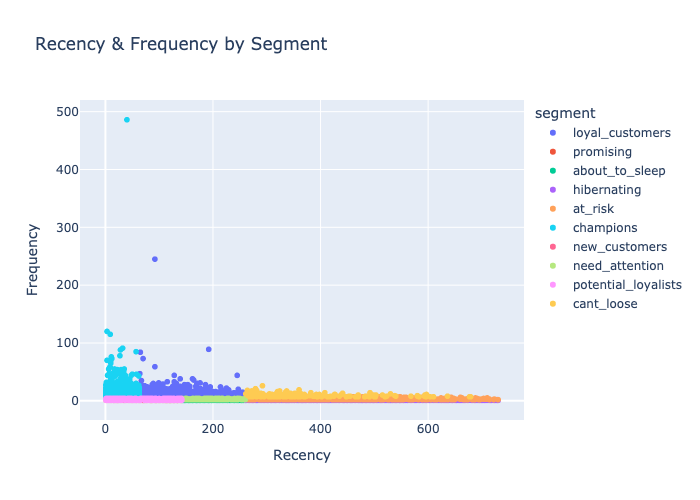

In [13]:
# Visualize Recency & Frequency by Segment
fig = px.scatter(rfm_df, x='Recency', y='Frequency', color='segment',
                 title='Recency & Frequency by Segment',
                 labels={'Frequency': 'Frequency', 'Recency': 'Recency'},
                 hover_data=['segment'])
fig.show()

#### Hibernating
- **Description**: Customers who haven't purchased for a long time and did so infrequently.
- **Action**: Re-engage with personalized promotions or surveys to understand their lack of activity.

#### At Risk
- **Description**: Customers who used to shop frequently but haven't returned for a while.
- **Action**: Send personalized reactivation campaigns, offer renewals, or release limited-time offers.

#### Can't Lose
- **Description**: Customers who purchased frequently in the past, but haven’t been seen in a while.
- **Action**: Implement high-value personalized retention plans, reach out directly to understand their needs, and make exclusive offers.

#### About to Sleep
- **Description**: Customers with infrequent purchases and who haven't purchased recently.
- **Action**: Wake them up with small offers or product reminders before they lapse.

#### Need Attention
- **Description**: Customers who have an average frequency and recency score.
- **Action**: Create loyalty programs or feedback loops to increase engagement.

#### Loyal Customers
- **Description**: Customers who purchase frequently.
- **Action**: Introduce loyalty programs, upsell products with higher value within their usual purchase range, and engage in cross-selling relevant products.

#### Promising
- **Description**: Customers who have made a purchase recently but do so infrequently.
- **Action**: Offer educational content about the product range or provide incentives for package deals.

#### New Customers
- **Description**: Customers who have made their first purchase recently.
- **Action**: Provide onboarding support, offer first-purchase discounts, and request feedback to improve their experience.

#### Potential Loyalists
- **Description**: Customers who have made a few purchases recently.
- **Action**: Encourage second purchase, offer membership or loyalty programs, and recommend products based on past purchases.

#### Champions
- **Description**: Customers who bought recently and buy often.
- **Action**: Reward with exclusive offers, leverage them for word-of-mouth promotion, and involve them in beta tests for new products.


## 2. K-means Clustering: The Blind Date with Data

Imagine you're on a blind date, but instead of meeting a person, you're meeting a wild, untamed dataset. You have no idea what to expect. Is it going to be love at first sight or a chaotic mess that makes you want to run for the hills? Enter K-means clustering, your wingman in the mysterious world of data relationships.

K-means doesn't care if your data is the life of the party or the shy one in the corner. It's like playing matchmaker at a masquerade ball, grouping together those who dance to the same rhythm, even if they can't see each other's faces. It's simple, it's straightforward, and it doesn't need to know the life story of your data to set up the perfect pairs.

So, why choose K-means for this adventurous endeavor? Because when you're stepping into the unknown, sometimes the best approach is to keep it simple and see where the night takes you. Let's dive into the party, shall we? K-means is ready to turn this blind date with data into a night to remember!

In [14]:
# Feature Extraction
customer_data = master_df.groupby('MemberID').agg(
    Monetary=('TicketSales', 'sum'),
    Frequency=('TicketSales', 'count')
).reset_index()

customer_data = pd.merge(member_df, customer_data, how='inner', on='MemberID')
# Scale Monetary to 1-100 as SpendingScore
customer_data['SpendingScore'] = customer_data['Monetary'].rank(method='max')
minimum = customer_data['SpendingScore'].min()
maximum = customer_data['SpendingScore'].max()
customer_data['SpendingScore'] = ((customer_data['SpendingScore'] - minimum) / (maximum - minimum) * 99 + 1).astype(int)
customer_data['FrequencyScore'] = customer_data['Frequency'].rank(method='max')
minimum = customer_data['FrequencyScore'].min()
maximum = customer_data['FrequencyScore'].max()
customer_data['FrequencyScore'] = ((customer_data['FrequencyScore'] - minimum) / (maximum - minimum) * 99 + 1).astype(int)
customer_data = customer_data[
    ['MemberID', 'Gender', 'ChildCounts', 'Age', 'SpendingScore', 'FrequencyScore']
    ]

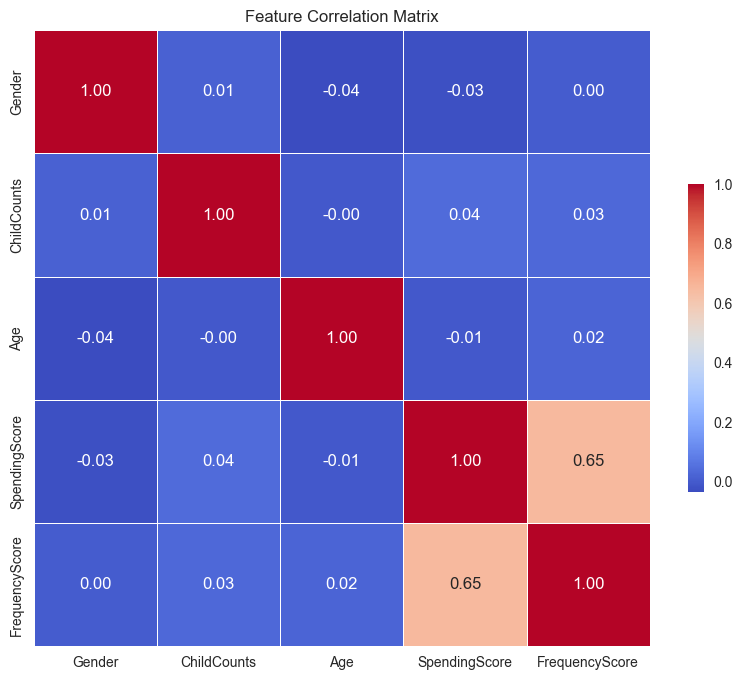

In [15]:
# Visualize feature correlation matrix
corr = customer_data[['Gender', 'ChildCounts', 'Age', 'SpendingScore', 'FrequencyScore']].copy()
corr['Gender'] = corr['Gender'].map({'Male': 0, 'Female': 1})
corr = corr.corr()
# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Feature Correlation Matrix')
plt.show()

In [16]:
# Use KMeans to cluster the data, and evaluate using Elbow Method & Silhouette Score
features = ['SpendingScore', 'ChildCounts', 'Age']
transformers = [
    ('num', StandardScaler(), ['SpendingScore', 'Age']),
    ('cat', OneHotEncoder(), ['ChildCounts'])
]
preprocessor = ColumnTransformer(transformers, remainder='passthrough')
train_df_preprocessed = preprocessor.fit_transform(customer_data[features])

inertia = []
silhouette_scores = []

range_n_clusters = range(2, 15)
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(train_df_preprocessed)
    inertia.append(kmeans.inertia_)
    # Calculate Silhouette Score, slowly
    silhouette_avg = silhouette_score(train_df_preprocessed, cluster_labels)
    silhouette_scores.append(silhouette_avg)

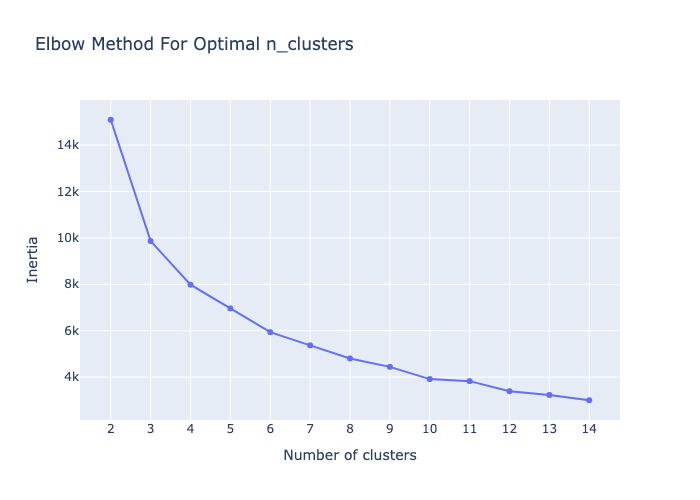

In [17]:
# Visualize the Elbow Curve, it sucks.
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range_n_clusters), y=inertia, mode='lines+markers', name='Inertia'))
fig.update_layout(title='Elbow Method For Optimal n_clusters',
                  xaxis_title='Number of clusters',
                  yaxis_title='Inertia',
                  xaxis=dict(tickmode='array', tickvals=list(range_n_clusters)))
fig.show()

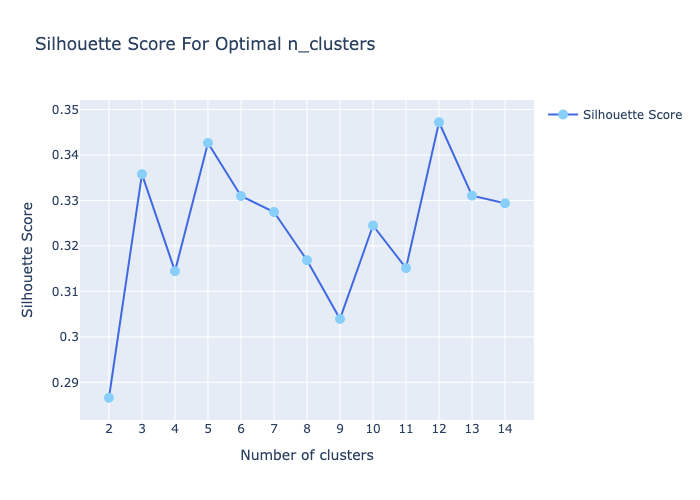

In [18]:
# Visualize Silhouette Score, seems better
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(2, len(silhouette_scores) + 2)), y=silhouette_scores, 
                         mode='lines+markers', name='Silhouette Score',
                         line=dict(color='RoyalBlue', width=2), marker=dict(color='LightSkyBlue', size=10)))

fig.update_layout(title='Silhouette Score For Optimal n_clusters',
                  xaxis_title='Number of clusters',
                  yaxis_title='Silhouette Score',
                  xaxis=dict(tickmode='linear', tick0=2, dtick=1),
                  showlegend=True)
fig.show()

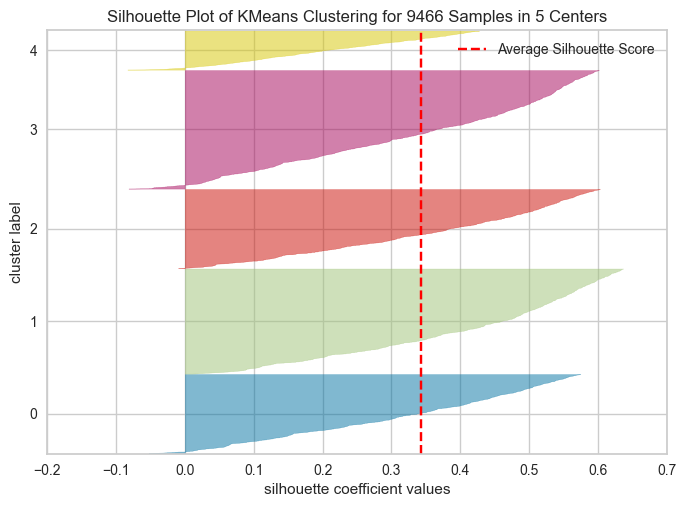

SilhouetteVisualizer(ax=<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 9466 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=5, random_state=42))

In [19]:
# Optimal number seens like 5, visualize the clusters using Silhouette Visualizer

kmeans = KMeans(n_clusters=5, random_state=42)
silhouette_visualizer(KMeans(n_clusters=5, random_state=42), train_df_preprocessed, colors='yellowbrick')

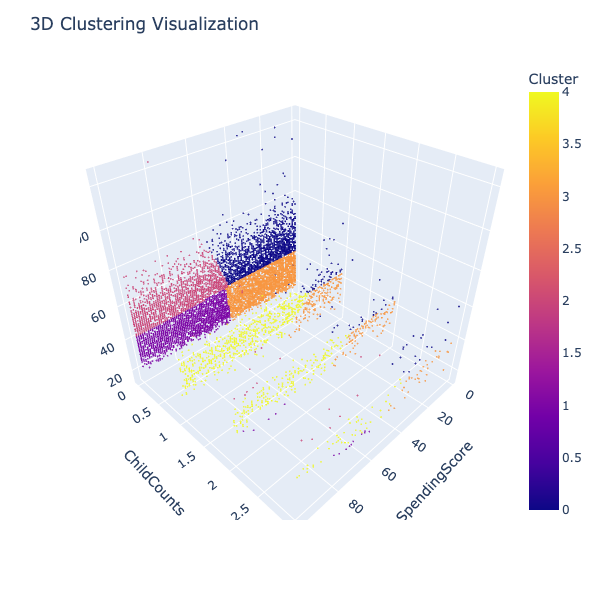

In [20]:
# Visualize the cluseters in 3D
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(train_df_preprocessed)
customer_data['Cluster'] = cluster_labels
fig = px.scatter_3d(customer_data, x='SpendingScore', y='ChildCounts', z='Age', color='Cluster', opacity=0.8)
fig.update_traces(marker=dict(size=1))
fig.update_layout(width=600, height=600, title='3D Clustering Visualization')
fig.show()

In [21]:
# Statistical information about each cluster
cluster_analysis = customer_data.groupby('Cluster').agg(
    Counts=('MemberID', 'count'),
    MaxSpendingScore=('SpendingScore', 'max'),
    MeanSpendingScore=('SpendingScore', 'mean'),
    MedianSpendingScore=('SpendingScore', 'median'),
    MinSpendingScore=('SpendingScore', 'min'),
    MaxAge=('Age', 'max'),
    MeanAge=('Age', 'mean'),
    MedianAge=('Age', 'median'),
    MinAge=('Age', 'min'),
    ChildCounts=('ChildCounts', 'mean')
)
cluster_analysis

,Counts,MaxSpendingScore,MeanSpendingScore,MedianSpendingScore,MinSpendingScore,MaxAge,MeanAge,MedianAge,MinAge,ChildCounts
Cluster,,,,,,,,,,
0,1782,57,25.053311,25.0,1,124,54.740741,53.0,44,0.092031
1,2365,99,73.031712,73.0,48,42,31.705285,32.0,18,0.016913
2,1777,99,75.465391,76.0,48,124,51.745639,50.0,42,0.027575
3,2666,49,23.563391,23.0,1,44,32.518755,33.0,15,0.173293
4,876,100,67.420091,68.0,25,59,40.001142,40.0,21,1.334475


## Customer Marketing Strategies by Cluster

**Cluster 0: Low Spenders, High Age, No Children**

* **Focus:** Value and convenience. 
* **Messaging:** Highlight affordability, easy use, and senior-friendly features. 
* **Channels:** Direct mail, print ads, TV commercials during daytime shows. 
* **Offers:** Discounts, bundled packages, loyalty programs.

**Cluster 1: High Spenders, Young Age, No Children**

* **Focus:** Latest trends and experiences. 
* **Messaging:**  Showcase new products, exclusive offers, and the "in" factor.
* **Channels:** Social media, influencer marketing, mobile apps.
* **Offers:** Limited-edition items, early access to new products, personalized recommendations.

**Cluster 2: High Spenders, High Age, No Children**

* **Focus:**  Quality, service, and reward programs. 
* **Messaging:**  Emphasize premium products, exceptional customer service, and loyalty benefits.
* **Channels:** Targeted email campaigns, webinars, events.
* **Offers:** Extended warranties, priority customer support, high-value rewards.

**Cluster 3: Low Spenders, Young Age, No Children**

* **Focus:** Budget-friendly options and building brand loyalty.
* **Messaging:**  Promote entry-level products, student discounts, and future benefits of brand loyalty.
* **Channels:** Social media contests, free trials, referral programs.
* **Offers:** Student discounts, free samples, gamified promotions.

**Cluster 4: High Spenders, Median Age, With Children**

* **Focus:**  Family-oriented solutions and convenience. 
* **Messaging:**  Showcase family-friendly products, time-saving solutions, and kid-approved benefits.
* **Channels:** Family-focused websites, parenting blogs, social media platforms.
* **Offers:**  Family bundles, bulk discounts, child-related promotions (e.g., back-to-school deals).


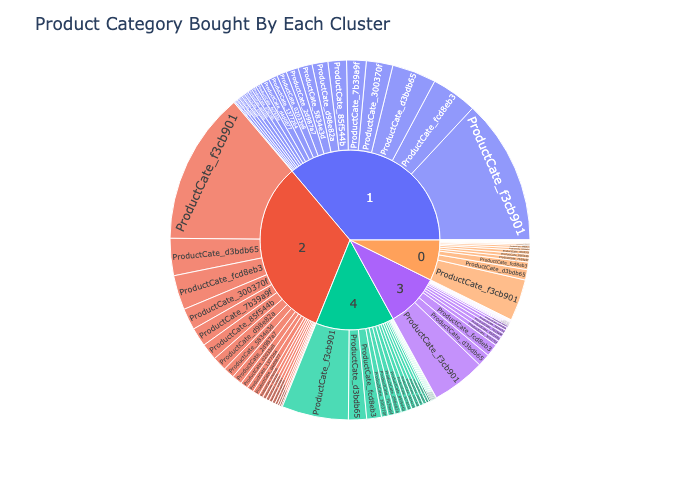

In [22]:
# Visualize Product Category bought by each cluster
cluster_product = pd.merge(detail_df, customer_data[['MemberID', 'Cluster']], how='inner', on='MemberID')
cluster_product = cluster_product.groupby(['Cluster', 'ProductCategory']).agg(
    Counts=('ProductCategory', 'count')
).reset_index()
fig = px.sunburst(cluster_product, path=['Cluster', 'ProductCategory'], values='Counts')
fig.update_layout(title='Product Category Bought By Each Cluster')
fig.show()

In [23]:
# TODO Validate the segmentation 